In [10]:
import talib as ta
import numpy as np
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import vectorbt as vbt
from datetime import datetime
import plotly.offline as pyo

In [11]:
#catch data
all_data = pd.read_csv('/Users/mona/Desktop/VS code/Quant/BTCUSDT-1h-data.csv')
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data = all_data.set_index('Timestamp')
all_data = all_data.iloc[3279:,:]
all_data = all_data.resample('2H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
all_data['Close'] = all_data['Close'].astype(float)

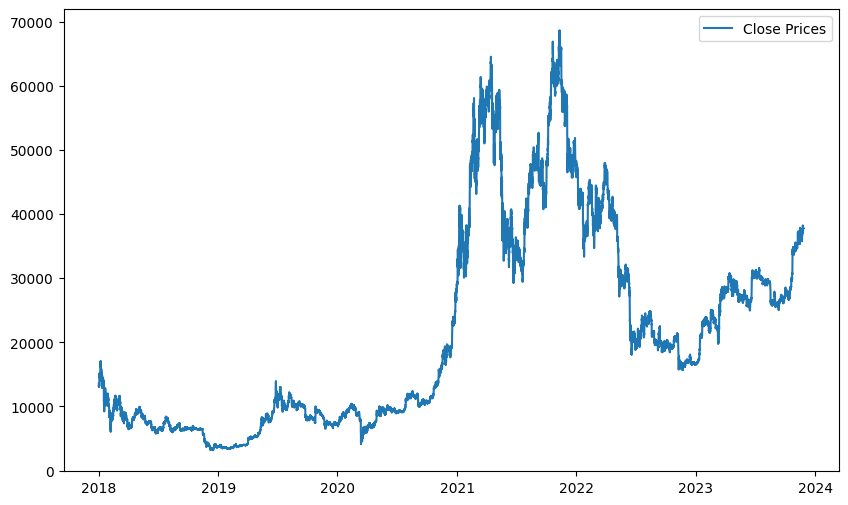

In [12]:
#plot
plt.figure(figsize=(10, 6))
plt.plot(all_data['Close'], label='Close Prices')
plt.legend()
plt.show()

In [13]:
# split
# split_index = int(len(all_data) * 0.7)
# train = all_data[:split_index]        
# test = all_data[split_index:]

train = all_data[:17431]        
test = all_data[17431:]

In [14]:
#def
def crossover(over, down):
    a1 = over
    b1 = down
    a2 = a1.shift(1)
    b2 = b1.shift(1)
    crossover = (a1 > a2) & (a1 > b1) & (b2 > a2)
    return crossover
def crossdown(down, over):
    a1 = down
    b1 = over
    a2 = a1.shift(1)
    b2 = b1.shift(1)
    crossdown = (a1 < a2) & (a1 < b1) & (b2 < a2)
    return crossdown

In [15]:
#define goal def

def objective(trial):
    rvi_length = trial.suggest_int('rvi_length', 2, 24)   # 4h-2d
    rvi_ma_length = trial.suggest_int('rvi_ma_length', 2, 24)
    kclength = trial.suggest_int('kclength', 2, 48)
    kc_mult = trial.suggest_float('kc_mult', 1.0, 3.5)

    #catch data
    df = train  

    price_diff = np.diff(df['Close'])
    df = df.iloc[1:, :]
    df['price_diff'] = price_diff
    df['stddev'] = df['Close'].rolling(window=rvi_length).std()
    df['upper'] = np.where(df['price_diff'] <= 0, 0, df['stddev'])
    df['upper'] = df['upper'].ewm(span=rvi_length, adjust=False).mean()
    df['lower'] = np.where(df['price_diff'] > 0, 0, df['stddev'])
    df['lower'] = df['lower'].ewm(span=rvi_length, adjust=False).mean()
    df['rvi'] = df['upper'] / (df['upper'] + df['lower']) *100
    df['rvi_ma'] = df['rvi'].rolling(rvi_ma_length).mean()
    df.dropna(inplace=True)

    df['sma'] = df['Close'].rolling(kclength).mean()
    df['basis'] = df['Close'].ewm(span=kclength, adjust=False).mean()
    df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=kclength)
    df['kc_upper'] = df['basis'] + kc_mult * df['atr']
    df['kc_lower'] = df['basis'] - kc_mult * df['atr']
    df.dropna(inplace=True)

    #signal
    signal = pd.DataFrame(columns=['long_entry', 'short_entry', 'long_exit', 'short_exit'])
    signal['long_entry'] = np.where((crossover(df['Close'], df['kc_upper']) & (df['rvi'] > df['rvi_ma'])), 1, 0)
    signal['long_exit'] = np.where((crossdown(df['Close'], df['basis']) & (df['rvi'] < df['rvi_ma'])), 1, 0)
    signal['short_entry'] = np.where((crossdown(df['Close'], df['kc_lower']) & (df['rvi'] < df['rvi_ma'])), 1, 0)
    signal['short_exit'] = np.where((crossover(df['Close'], df['basis']) & (df['rvi'] > df['rvi_ma'])), 1, 0)
    
    #pf
    price = df['Open'].shift(-1)
    pf = vbt.Portfolio.from_signals(price,
                                entries = signal['long_entry'],
                                exits = signal['long_exit'],
                                short_entries = signal['short_entry'],
                                short_exits = signal['short_exit'],
                                freq='2H',
                                fees = 0.0005)
    
    a = pf.stats()

    return a['Total Return [%]']

#Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

#get best params
print(f'Best Parameters:{study.best_params}')
print("Best value:", study.best_value)

[I 2024-01-10 20:36:49,329] A new study created in memory with name: no-name-443fc1ed-e5ba-4621-bcd0-2928746cc869
/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/2433741803.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/2433741803.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/2433741803.py:16: SettingWithCopyWarning:


A value is trying to be set on 

Best Parameters:{'rvi_length': 2, 'rvi_ma_length': 18, 'kclength': 31, 'kc_mult': 2.0705197405541274}
Best value: 2298.4949376624913


In [16]:
#train result
rvi_length = study.best_params['rvi_length']
rvi_ma_length = study.best_params['rvi_ma_length']
kclength = study.best_params['kclength']
kc_mult = study.best_params['kc_mult']

#catch data
df = train

price_diff = np.diff(df['Close'])
df = df.iloc[1:, :]
df['price_diff'] = price_diff
df['stddev'] = df['Close'].rolling(window=rvi_length).std()
df['upper'] = np.where(df['price_diff'] <= 0, 0, df['stddev'])
df['upper'] = df['upper'].ewm(span=rvi_length, adjust=False).mean()
df['lower'] = np.where(df['price_diff'] > 0, 0, df['stddev'])
df['lower'] = df['lower'].ewm(span=rvi_length, adjust=False).mean()
df['rvi'] = df['upper'] / (df['upper'] + df['lower']) *100
df['rvi_ma'] = df['rvi'].rolling(rvi_ma_length).mean()
df.dropna(inplace=True)

df['sma'] = df['Close'].rolling(kclength).mean()
df['basis'] = df['Close'].ewm(span=kclength, adjust=False).mean()
df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=kclength)
df['kc_upper'] = df['basis'] + kc_mult * df['atr']
df['kc_lower'] = df['basis'] - kc_mult * df['atr']
df.dropna(inplace=True)

#signal
signal = pd.DataFrame(columns=['long_entry', 'short_entry', 'long_exit', 'short_exit'])
signal['long_entry'] = np.where((crossover(df['Close'], df['kc_upper']) & (df['rvi'] > df['rvi_ma'])), 1, 0)
signal['long_exit'] = np.where((crossdown(df['Close'], df['basis']) & (df['rvi'] < df['rvi_ma'])), 1, 0)  # basis or sma?
signal['short_entry'] = np.where((crossdown(df['Close'], df['kc_lower']) & (df['rvi'] < df['rvi_ma'])), 1, 0)
signal['short_exit'] = np.where((crossover(df['Close'], df['basis']) & (df['rvi'] > df['rvi_ma'])), 1, 0)

#pf
price = df['Open'].shift(-1)
pf = vbt.Portfolio.from_signals(price,
                            entries = signal['long_entry'],
                            exits = signal['long_exit'],
                            short_entries = signal['short_entry'],
                            short_exits = signal['short_exit'],
                            freq='2H',
                            fees = 0.0005)

print(pf.stats())
fig = pf.plot(subplots=['cum_returns', 'orders', 'trade_pnl'])
pyo.plot(fig)


/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/2837148294.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/2837148294.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/2837148294.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Start                         2018-01-05 04:00:00
End                           2021-12-23 12:00:00
Period                         1442 days 18:00:00
Start Value                                 100.0
End Value                             2398.494938
Total Return [%]                      2298.494938
Benchmark Return [%]                   222.386559
Max Gross Exposure [%]                      100.0
Total Fees Paid                          6.115165
Max Drawdown [%]                           29.638
Max Drawdown Duration           307 days 02:00:00
Total Trades                                   10
Total Closed Trades                            10
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 90.0
Best Trade [%]                         311.253024
Worst Trade [%]                        -15.284966
Avg Winning Trade [%]                   60.763407
Avg Losing Trade [%]                   -15.284966


'temp-plot.html'

In [17]:
#test result
df = test

price_diff = np.diff(df['Close'])
df = df.iloc[1:, :]
df['price_diff'] = price_diff
df['stddev'] = df['Close'].rolling(window=rvi_length).std()
df['upper'] = np.where(df['price_diff'] <= 0, 0, df['stddev'])
df['upper'] = df['upper'].ewm(span=rvi_length, adjust=False).mean()
df['lower'] = np.where(df['price_diff'] > 0, 0, df['stddev'])
df['lower'] = df['lower'].ewm(span=rvi_length, adjust=False).mean()
df['rvi'] = df['upper'] / (df['upper'] + df['lower']) *100
df['rvi_ma'] = df['rvi'].rolling(rvi_ma_length).mean()
df.dropna(inplace=True)

df['sma'] = df['Close'].rolling(kclength).mean()
df['basis'] = df['Close'].ewm(span=kclength, adjust=False).mean()
df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=kclength)
df['kc_upper'] = df['basis'] + kc_mult * df['atr']
df['kc_lower'] = df['basis'] - kc_mult * df['atr']
df.dropna(inplace=True)

#signal
signal = pd.DataFrame(columns=['long_entry', 'short_entry', 'long_exit', 'short_exit'])
signal['long_entry'] = np.where((crossover(df['Close'], df['kc_upper']) & (df['rvi'] > df['rvi_ma'])), 1, 0)
signal['long_exit'] = np.where((crossdown(df['Close'], df['basis']) & (df['rvi'] < df['rvi_ma'])), 1, 0)  # basis or sma?
signal['short_entry'] = np.where((crossdown(df['Close'], df['kc_lower']) & (df['rvi'] < df['rvi_ma'])), 1, 0)
signal['short_exit'] = np.where((crossover(df['Close'], df['basis']) & (df['rvi'] > df['rvi_ma'])), 1, 0)

#pf
price = df['Open'].shift(-1)
pf = vbt.Portfolio.from_signals(price,
                            entries = signal['long_entry'],
                            exits = signal['long_exit'],
                            short_entries = signal['short_entry'],
                            short_exits = signal['short_exit'],
                            freq='2H',
                            fees = 0.0005)

print(pf.stats())
fig = pf.plot(subplots=['cum_returns', 'orders', 'trade_pnl'])
pyo.plot(fig)

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/191080597.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/191080597.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yh/bc0lmksx0r7d3c5vvvydzmfr0000gn/T/ipykernel_47648/191080597.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Start                         2021-12-27 18:00:00
End                           2023-11-26 06:00:00
Period                          698 days 14:00:00
Start Value                                 100.0
End Value                               63.090972
Total Return [%]                       -36.909028
Benchmark Return [%]                   -26.230879
Max Gross Exposure [%]                      100.0
Total Fees Paid                          0.350096
Max Drawdown [%]                         56.26084
Max Drawdown Duration           563 days 02:00:00
Total Trades                                    5
Total Closed Trades                             5
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 40.0
Best Trade [%]                          14.923763
Worst Trade [%]                        -41.819042
Avg Winning Trade [%]                    9.365322
Avg Losing Trade [%]                   -16.996881


'temp-plot.html'